# Read in the data

In [3]:
import pandas as pd
import matplotlib as plt
import numpy
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [29]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


# Add a school district column for mapping

In [35]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,88,384.0,409.0,361.0,1154.0,EBC-HS FOR PUB SERVICE (BUSH),47.000000,64.000000,...,0,0,0,0.0,0.0,0.0,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",40.694482,-73.929154,32
359,32K549,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,75,348.0,353.0,334.0,1035.0,0,129.028846,197.038462,...,Then to Brooklyn students or residents,Then to New York City residents,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32
360,32K552,ACADEMY OF URBAN PLANNING,67,342.0,364.0,354.0,1060.0,Academy of Urban Planning,76.000000,100.000000,...,0,0,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32
361,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,39,428.0,465.0,422.0,1315.0,All City Leadership Secondary School,7.000000,8.000000,...,"Then to Districts 24, 30 and 32 students or re...",Then to Brooklyn students or residents,Then to New York City residents,0.0,0.0,0.0,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",40.697408,-73.913153,32


# Find correlations

In [28]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

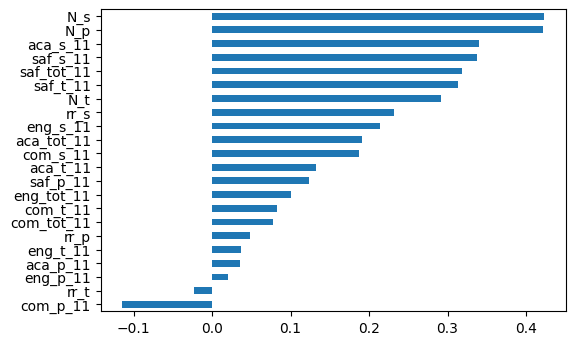

In [20]:
correlations = combined[survey_fields].corrwith(combined['sat_score']).sort_values()
correlations.plot(kind = 'barh')

There is a strong correlation with the number of students and teachers, so we confirm that bigger schools perform better

Also we find a strong correlation with students' academic expectations and safety and respect scores. Let's dig into this relationship and try to figure out which schools have low safety scores.

## Safety

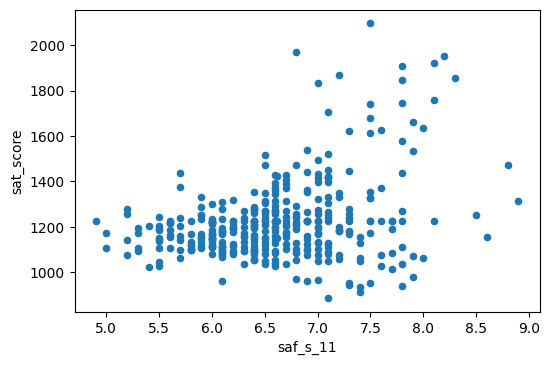

In [23]:
combined.plot(kind = 'scatter',x = 'saf_s_11', y = 'sat_score')

We confirm a weak positive correlation but we notice that schools where students perceive a lower safety and respect have sat score below 1300 points. Instead, schools with a better safety score span on a greater range.
Let's see is safety score is related to the school position.

In [41]:
combined.groupby(by ='boro').agg(numpy.mean)['saf_s_11']

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Manhattan and Queens have higher safety scores, Brooklyn the lowest one.

## Race

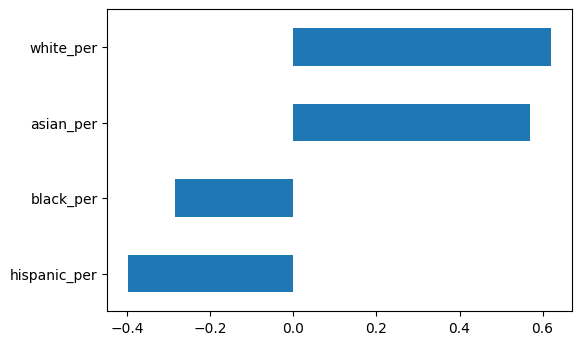

In [47]:
races_cols = [
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per'
]

correlations = combined[races_cols].corrwith(combined['sat_score']).sort_values()
correlations.plot(kind = 'barh')

Apparently SAT survey have different outcomes depending on a race component.

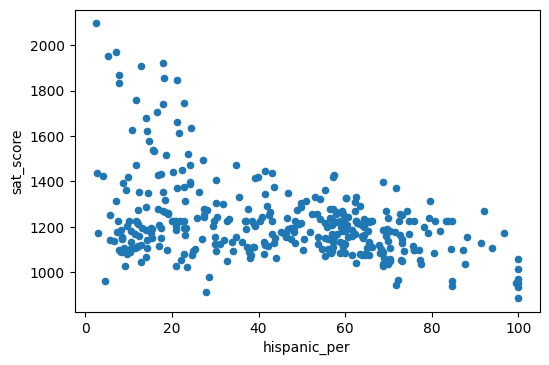

In [48]:
combined.plot(kind = 'scatter', x = 'hispanic_per', y = 'sat_score')

Data are more dispersed but reach higher score where hispanic student are fewer. There are a small number of school with 100% hispanic students with low score. Let's see them more closely:

In [54]:
combined.loc[combined['hispanic_per']>95, ['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0
253,MULTICULTURAL HIGH SCHOOL,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0


Many of these schools are oriented to immigrants and some contents of their website are in spanish.

Let's see now the opposite case, where hispanic are fewer and sat score is higher.

In [56]:
combined.loc[(combined['hispanic_per']<10) & (combined['sat_score']>1800) , ['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
37,STUYVESANT HIGH SCHOOL,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0


All these schools are highly selective, and often require an admission test.

## Gender

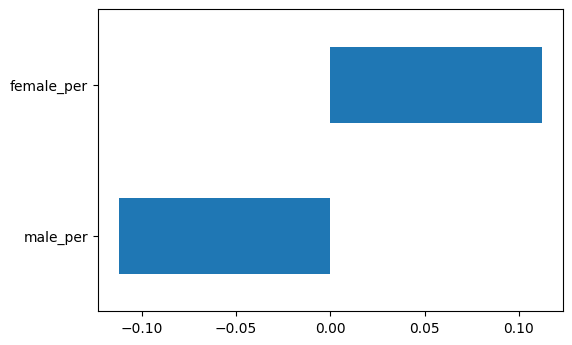

In [58]:
correlations = combined[['male_per', 'female_per']].corrwith(combined['sat_score']).sort_values()
correlations.plot(kind = 'barh')

There is a weak positive correlation with percentage of female students, suggesting that girls may perform better in the test. Let's see a scatter plot:

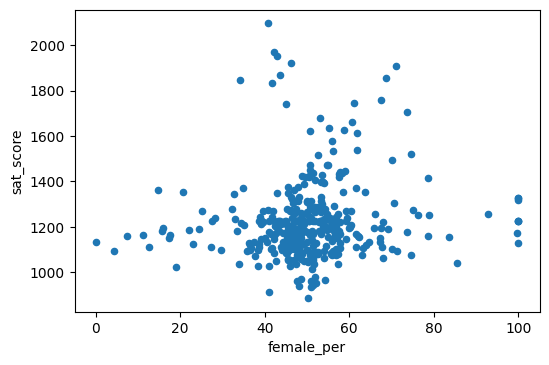

In [59]:
combined.plot(kind = 'scatter', x = 'female_per', y = 'sat_score')

I can't see any pattern in this plot. Let's see what happens with the best performing schools with greater percentage of female students.

In [60]:
combined.loc[(combined['female_per']>60) & (combined['sat_score']>1700) , ['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
60,BEACON HIGH SCHOOL,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0
